# Data Science Regression Project -> Predicting Home Prices of Banglore City

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10) 

# Data Load: Load banglore home prices into a dataframe

In [2]:
data = pd.read_csv("Banglore.csv")
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
data.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

### Drop features that are not required to build our model

In [4]:
data2 = data.drop(['area_type','society','balcony','availability'],axis="columns")      # Dropped these columns as these are not too important to predict price
data2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Data Cleaning: Handle NA values

In [5]:
data2.isnull().sum()    # gives us the number of particular rows where the values are na

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [6]:
# As the number of na values are very less we can safely remove them from the data

data3 = data2.dropna()
data3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [7]:
data3.shape

(13246, 5)

In [8]:
# The size column have different type of values

data3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

# Feature Engineering
### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [9]:
# To make is useful for the data we add a new column, then apply a function just to take the numbers from it

data3['bhk'] = data3['size'].apply(lambda x: int(x.split(' ')[0]))
data3.bhk.unique()

<ipython-input-9-0f8ee83cb75f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['bhk'] = data3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [10]:
# I want to check now what kind of home provides 43 bhk

data3[data3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [11]:
# Here we can see 43 bhk with 2400sqft which is not so possible,
# Hence we need to tackle this kind of problems,
# Before that, lets explore total_sqft

data3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

### Explore total_sqft

In [12]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

data3[~data3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [13]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

data4 = data3.copy()
data4.total_sqft = data4.total_sqft.apply(convert_sqft_to_num)
data4 = data4[data4.total_sqft.notnull()]
data4 = data4.drop(['size'],axis='columns')
data4.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


# Feature Engineering
### Add new feature called price per square feet

In [14]:
data5 = data4.copy()
data5['price_per_sqft'] = data5['price']*100000/data5['total_sqft']
data5.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [15]:
len(data5.location.unique())

1298

### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [16]:
data5.location = data5.location.apply(lambda x: x.strip())
location_stats = data5['location'].value_counts(ascending=False)
location_stats

Whitefield            533
Sarjapur  Road        392
Electronic City       304
Kanakpura Road        264
Thanisandra           235
                     ... 
West of Chord Road      1
Old Town                1
GB Palya                1
Chambenahalli           1
Subramanya Nagar        1
Name: location, Length: 1287, dtype: int64

In [17]:
len(location_stats[location_stats>10])

240

In [18]:
len(location_stats[location_stats<=10])

1047

# Dimensionality Reduction
### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [19]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Kalkere                  10
1st Block Koramangala    10
Dodsworth Layout         10
Dairy Circle             10
Sadashiva Nagar          10
                         ..
West of Chord Road        1
Old Town                  1
GB Palya                  1
Chambenahalli             1
Subramanya Nagar          1
Name: location, Length: 1047, dtype: int64

In [20]:
len(data5.location.unique())

1287

In [21]:
data5.location = data5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(data5.location.unique())

241

In [22]:
data5.head(10)

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,1310.0,3.0,63.25,3,4828.244275
9,other,1020.0,6.0,370.00,6,36274.509804


# Outlier Removal Using Business Logic
### As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [23]:
data5[data5.total_sqft/data5.bhk<300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000


### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [24]:
data6 = data5[~(data5.total_sqft/data5.bhk<300)]
data6.shape

(12456, 6)

# Outlier Removal Using Standard Deviation and Mean

In [25]:
data6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

### Here we find that min price per sqft is ₹267/sqft whereas max is ₹12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [26]:
def remove_pps_outliers(data):
    data_out = pd.DataFrame()
    for key, subdata in data.groupby('location'):
        m = np.mean(subdata.price_per_sqft)
        st = np.std(subdata.price_per_sqft)
        reduced_data = subdata[(subdata.price_per_sqft>(m-st)) & (subdata.price_per_sqft<=(m+st))]
        data_out = pd.concat([data_out,reduced_data],ignore_index=True)
    return data_out

data7 = remove_pps_outliers(data6)
data7.shape

(10242, 6)

### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

In [27]:
def plot_scatter_chart(data,location):
    bhk2 = data[(data.location==location) & (data.bhk==2)]
    bhk3 = data[(data.location==location) & (data.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,marker='.', color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

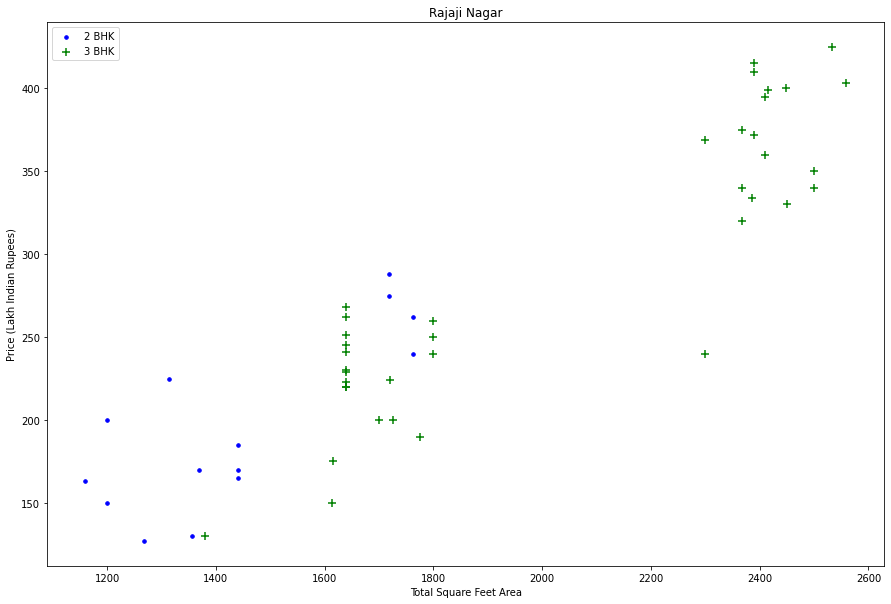

In [28]:
plot_scatter_chart(data7,"Rajaji Nagar")

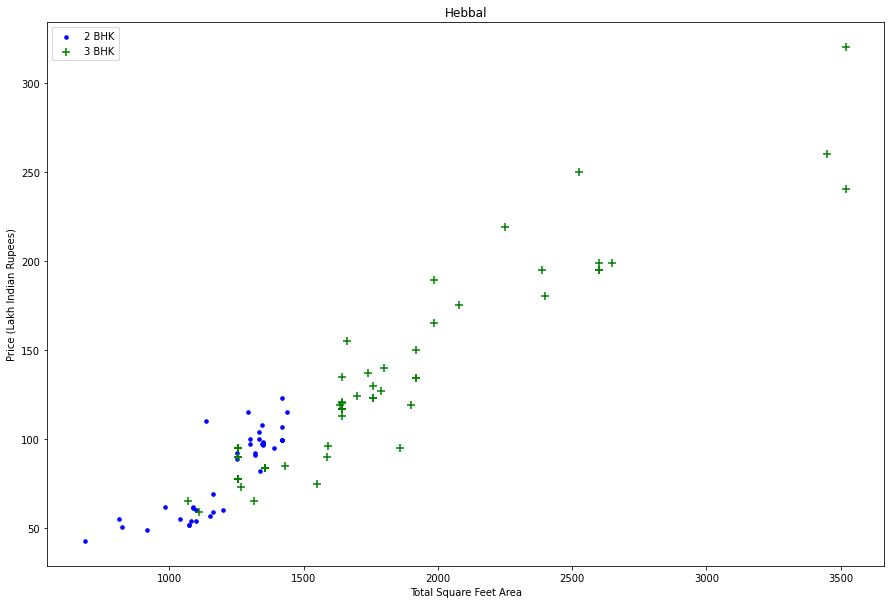

In [29]:
plot_scatter_chart(data7,"Hebbal")

### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
### Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [30]:
def remove_bhk_outliers(data):
    exclude_indices = np.array([])
    for location, location_data in data.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_data in location_data.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_data.price_per_sqft),
                'std': np.std(bhk_data.price_per_sqft),
                'count': bhk_data.shape[0]
            }
        for bhk, bhk_data in location_data.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_data[bhk_data.price_per_sqft<(stats['mean'])].index.values)
    return data.drop(exclude_indices,axis='index')
    
data8 = remove_bhk_outliers(data7)
data8.shape

(7317, 6)

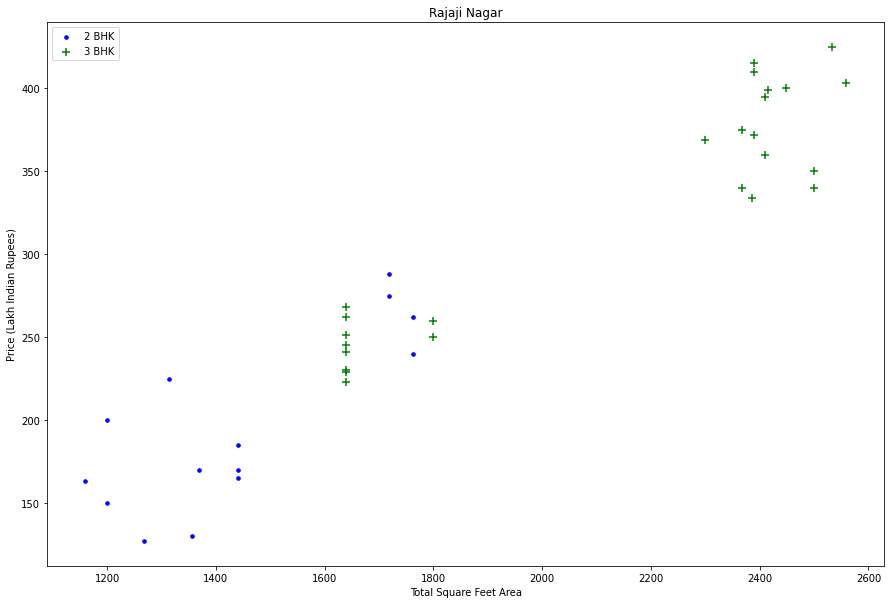

In [31]:
plot_scatter_chart(data8,"Rajaji Nagar")

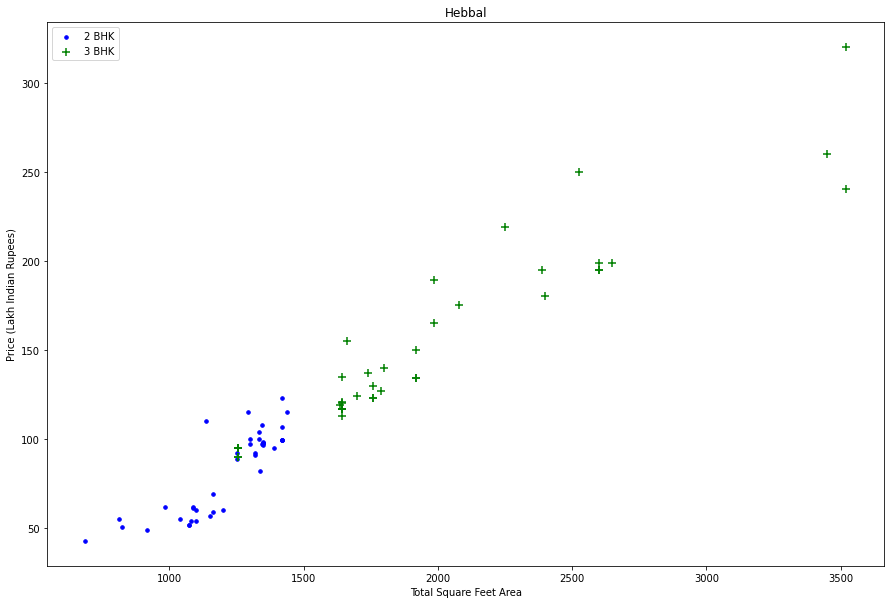

In [32]:
plot_scatter_chart(data8,"Hebbal")

# Outlier Removal Using Bathrooms Feature

In [33]:
data8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

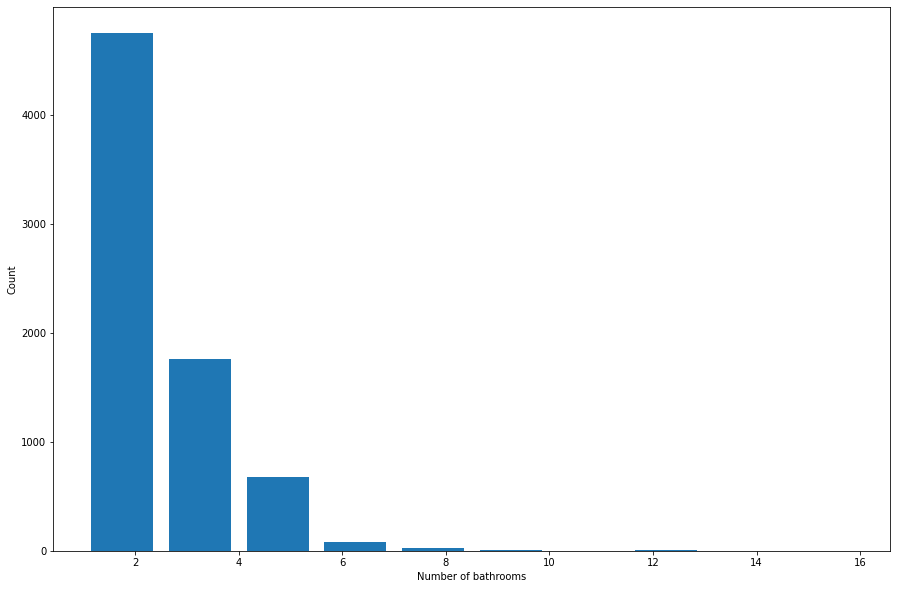

In [34]:
plt.hist(data8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [35]:
data8[data8.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8483,other,12000.0,12.0,525.0,10,4375.000000
8572,other,10000.0,16.0,550.0,16,5500.000000
9306,other,6000.0,12.0,150.0,11,2500.000000
9637,other,5425.0,13.0,275.0,13,5069.124424


### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [36]:
data8[data8.bath>data8.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,1806.0,6.0,116.0,3,6423.034330
8408,other,11338.0,9.0,1000.0,6,8819.897689


### Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [37]:
data9 = data8[data8.bath<data8.bhk+2]
data9.shape

(7239, 6)

In [38]:
data10 = data9.drop(['price_per_sqft'],axis='columns')
data10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


# Use One Hot Encoding For Location

In [39]:
dummies = pd.get_dummies(data10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
data11 = pd.concat([data10,dummies.drop('other',axis='columns')],axis='columns')
data11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
data12 = data11.drop('location',axis='columns')
data12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Build a Model Now...

In [42]:
x = data12.drop(['price'],axis='columns')
y = data12.price

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=10)

In [43]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.862913224522944

# Use K Fold cross validation to measure accuracy of our LinearRegression model

In [44]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

### We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

# Find best model using GridSearchCV

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': True}
1,lasso,0.726752,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.717859,"{'criterion': 'mse', 'splitter': 'random'}"


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

# Test the model for few properties

In [46]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(x.columns==location)[0][0]

    z = np.zeros(len(x.columns))
    z[0] = sqft
    z[1] = bath
    z[2] = bhk
    if loc_index >= 0:
        z[loc_index] = 1

    return lr_clf.predict([z])[0]

In [47]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

83.86570258312685

In [48]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

86.08062284987459

In [49]:
predict_price('Indira Nagar',1000, 2, 2)

193.31197733180053

In [50]:
predict_price('Indira Nagar',1000, 3, 3)

195.52689759854826

# Export the tested model to a pickle file

In [51]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

# Export location and column information to a file that will be useful later on in our prediction application

In [52]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [53]:
data12.to_csv("clean_dataset.csv",index=False)